In [31]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [32]:
def load_dataset(csv_path):
    df = pd.read_csv(csv_path, sep= ';')
    required_columns = ['Azimuth', 'Altitude', 'Timestamp']

    if not all (col in df.columns for col in required_columns):
        raise ValueError("Required columns are not present in the DataFrame.")
    
    X = df['Timestamp'].values.reshape(-1, 1)
    y = df['Azimuth'].values

    return X, y, df

In [33]:
csv_path = 'cleaned/cleaned_data_quartal_1_2020.csv'
X, y, df = load_dataset(csv_path)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state= 42)

In [35]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [36]:
timesteps = 1

In [37]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

In [42]:
model = Sequential()
model.add(LSTM(units=1024, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1]), return_sequences=True))
model.add(LSTM(units=512, activation= 'relu', return_sequences=True))
model.add(LSTM(units=128, activation= 'relu'))
model.add(Dense(units=1))

optimizer = Adam(learning_rate= 0.001)
model.compile(optimizer=optimizer, loss = 'mse')

model.fit(X_train_reshaped, y_train_scaled, epochs= 100, batch_size = 128)

Epoch 1/100
82/82 [==============================] - 5s 21ms/step - loss: 0.1004
Epoch 2/100
82/82 [==============================] - 2s 19ms/step - loss: 0.0443
Epoch 3/100
82/82 [==============================] - 2s 22ms/step - loss: 0.0429
Epoch 4/100
82/82 [==============================] - 2s 22ms/step - loss: 0.0428
Epoch 5/100
82/82 [==============================] - 2s 22ms/step - loss: 0.0427
Epoch 6/100
82/82 [==============================] - 2s 20ms/step - loss: 0.0430
Epoch 7/100
82/82 [==============================] - 2s 19ms/step - loss: 0.0429
Epoch 8/100
82/82 [==============================] - 1s 18ms/step - loss: 0.0427
Epoch 9/100
82/82 [==============================] - 2s 19ms/step - loss: 0.0427
Epoch 10/100
82/82 [==============================] - 2s 19ms/step - loss: 0.0427
Epoch 11/100
82/82 [==============================] - 2s 20ms/step - loss: 0.0428
Epoch 12/100
82/82 [==============================] - 2s 18ms/step - loss: 0.0428
Epoch 13/100
82/82 [=====

In [41]:
predicted_values_scaled = model.predict(X_test_reshaped)
predicted_values = scaler_y.inverse_transform(predicted_values_scaled)
mse = mean_squared_error(y_test_scaled, predicted_values_scaled)
print(f"Mean Squared Error on Test Data: {mse}")

82/82 [==============================] - 0s 5ms/step
Mean Squared Error on Test Data: 0.04262449596732471


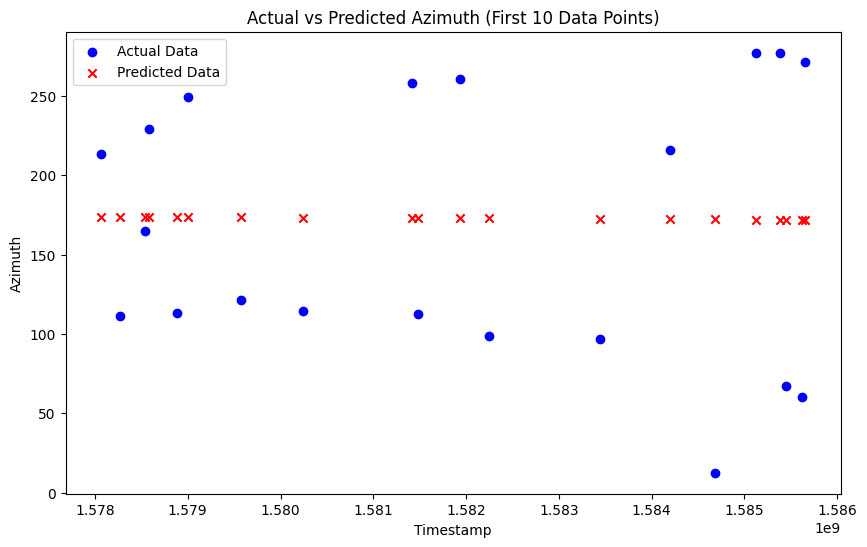

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:20], y_test[:20], label='Actual Data', color='blue')
plt.scatter(X_test[:20], predicted_values[:20], label='Predicted Data', color='red', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Azimuth')
plt.title('Actual vs Predicted Azimuth (First 10 Data Points)')
plt.legend()
plt.show()